In [4]:
from scipy.io import arff
from operator import index

import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.stattools import medcouple

plt.rcParams['figure.figsize'] = [15, 7]

In [7]:
arff_file = arff.loadarff('./clusters/artificial/cluto-t4-8k.arff')
df = pd.DataFrame(arff_file[0])

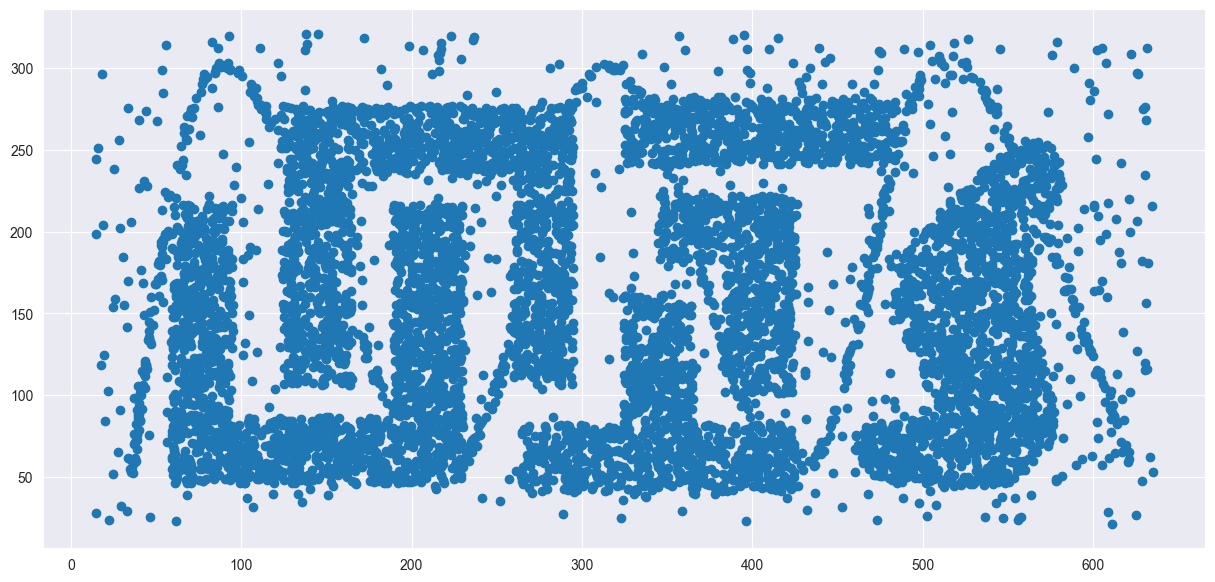

In [8]:
plt.scatter(df['x'],df['y'])
plt.show()

In [15]:
X = df.iloc[:,:2].values
y = df.iloc[:,2].values
print(X,y)

[[ 68.601997 102.491997]
 [454.665985 264.80899 ]
 [101.283997 169.285995]
 ...
 [267.605011 141.725006]
 [238.358002 252.729996]
 [159.242004 177.431   ]] [b'0' b'2' b'noise' ... b'1' b'1' b'1']


In [16]:
def main(X,y,n):
    nn = NearestNeighbors(n_neighbors=n)
    nn.fit(X, y)
    dist, knn = nn.kneighbors(X)  # returns N index neighbors including self
    return knn, dist

knn, distReturn = main(X,y,7)

In [18]:
def generateArr(newDist, median='median'):
    arr = []
    for x in newDist:  # finds the distance away from that point (index 0)
        if median == 'median':
            arr += [np.median(x)]
        elif median == 'sum': # min + median + max
            arr += [x[1]+np.max(x)+np.median(x)]
        elif median == 'max':
            arr += [np.max(x)]
        elif median == 'minMax':
            arr += [np.max(x)+x[1]]
        elif median == 'medMax':
            arr += [np.median(x)+np.max(x)]
        elif median == 'min':
            arr += [x[1]]
            

    return arr

distReturn = np.array(distReturn)
arr = generateArr(distReturn, median="max")

0.5354576521741912 3.834265620906856
2.2278926643842825


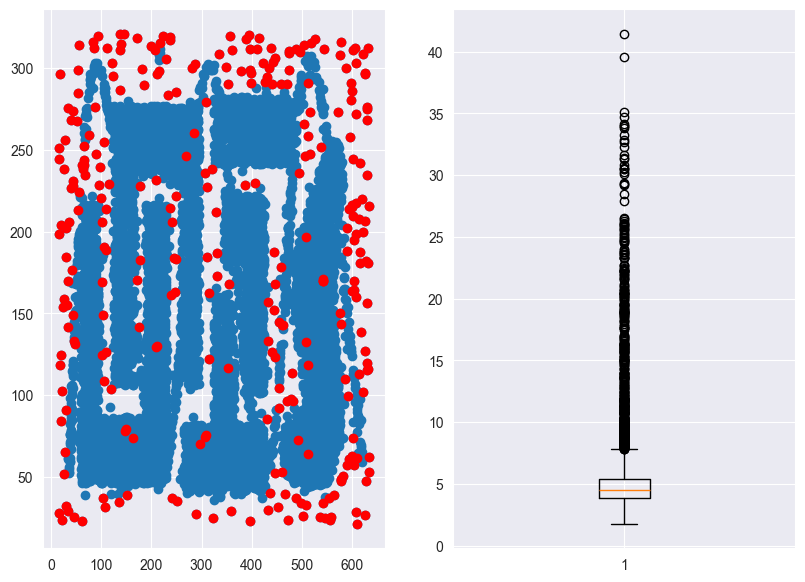

300
0 0.0 0 0.0


In [20]:
def boxplot7a(distO, X):
    outliers = []
    outliersIndex = []
    distO = np.array(distO)
    percent = np.quantile(distO, [.25, .50, .75])

    zU = np.sqrt(np.var(distO[distO >= percent[1]]))
    zL = np.sqrt(np.var(distO[distO < percent[1]]))
    print(zL, percent[0])

    upperL = percent[2] + 1.5 * zU
    lowerL = percent[0] - 3 * zL
    print(lowerL)

    for x in range(distO.shape[0]):
        if distO[x] > upperL:
            outliers += [X[x]]
            outliersIndex += [x]
        elif distO[x] < lowerL:
            outliers += [X[x]]
            outliersIndex += [x]

    return outliers, outliersIndex


outliers, indexOutliers = boxplot7a(arr, X)


def printer7a(distO, X, y, outliers):
    outliers = np.array(outliers)
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(outliers[:, 0], outliers[:, 1], c="red")
    plt.subplot(1, 3, 2)
    #plt.hist(self.X[:,0],bins=15)
    plt.boxplot(distO, vert=True)
    plt.show()


printer7a(arr, X, y, outliers)
print(len(outliers))
TruePositive = 0
FalsePositive = 0
indexOutliers = np.array(indexOutliers)
trueIndex = []
falseIndex = []
for x in indexOutliers:
    if y[x] == 1:
        TruePositive += 1
        trueIndex.append(x)
    if y[x] == 0:
        FalsePositive += 1
        falseIndex.append(x)

trueIndex = np.array(X[trueIndex])
falseIndex = np.array(X[falseIndex])
print(TruePositive, (TruePositive / indexOutliers.size), FalsePositive, (FalsePositive / indexOutliers.size))